In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2022-05-20 01:08:05--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  20.1MB/s    in 14s     

2022-05-20 01:08:20 (18.6 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
import pyspark
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('CatchPinkFlamingo').getOrCreate()

# Read data from CSV file
combinedData=spark.read.csv('/content/combined-data1.csv', header=True, inferSchema=True)
combinedData.show(5)

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 5 rows



In [ ]:
combinedData.count()

4619

In [ ]:
combinedData1=combinedData.withColumn("hit_accuracy", (combinedData.count_hits/combinedData.count_gameclicks))
combinedData1.show(5)


+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|       hit_accuracy|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|0.11594202898550725|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|0.16129032258064516|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|0.07692307692307693|
|  1863|         5651|        1|     android|              35|         4|       null|     null|0.11428571428571428|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|                0.0|
+------+-------------+---------+------------+----------------+----------

In [ ]:
# Remove the 'userId' column
combined_data_drop_column = combinedData1.drop('userSessionId','platformType')
# Number of records with missing 'avg_price' values
combined_data_drop_column.filter('avg_price is NULL').count()

# Remove records with missing 'avg_price' values
valid_avg_price = combined_data_drop_column.filter('avg_price IS NOT NULL')

# Remove records with missing values in any column and get the number of remaining rows
cleanData = valid_avg_price.dropna()
print(cleanData.count())

1411


In [ ]:
cleanData.show()

+------+---------+----------------+----------+-----------+---------+--------------------+
|userId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|        hit_accuracy|
+------+---------+----------------+----------+-----------+---------+--------------------+
|   937|        1|              39|         0|          1|      1.0|                 0.0|
|  1623|        1|             129|         9|          1|     10.0| 0.06976744186046512|
|    83|        1|             102|        14|          1|      5.0| 0.13725490196078433|
|   121|        1|              39|         4|          1|      3.0| 0.10256410256410256|
|   462|        1|              90|        10|          1|      3.0|  0.1111111111111111|
|   819|        1|              51|         8|          1|     20.0|  0.1568627450980392|
|  2199|        1|              51|         6|          2|      2.5| 0.11764705882352941|
|  1143|        1|              47|         5|          2|      2.0| 0.10638297872340426|
|  1652|  

In [ ]:
cleanData=cleanData.withColumn("revenue", (cleanData.count_buyId*cleanData.avg_price))
cleanData.show()
cleanData.count()

+------+---------+----------------+----------+-----------+---------+--------------------+-------+
|userId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|        hit_accuracy|revenue|
+------+---------+----------------+----------+-----------+---------+--------------------+-------+
|   937|        1|              39|         0|          1|      1.0|                 0.0|    1.0|
|  1623|        1|             129|         9|          1|     10.0| 0.06976744186046512|   10.0|
|    83|        1|             102|        14|          1|      5.0| 0.13725490196078433|    5.0|
|   121|        1|              39|         4|          1|      3.0| 0.10256410256410256|    3.0|
|   462|        1|              90|        10|          1|      3.0|  0.1111111111111111|    3.0|
|   819|        1|              51|         8|          1|     20.0|  0.1568627450980392|   20.0|
|  2199|        1|              51|         6|          2|      2.5| 0.11764705882352941|    5.0|
|  1143|        1|  

1411

In [ ]:
cleanData.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- hit_accuracy: double (nullable = true)
 |-- revenue: double (nullable = true)



In [ ]:
cleanData.columns

['userId',
 'teamLevel',
 'count_gameclicks',
 'count_hits',
 'count_buyId',
 'avg_price',
 'hit_accuracy',
 'revenue']

In [ ]:
cleanData.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
userId,1411,1201.0751240255138,691.9957569853385,1,2387
teamLevel,1411,4.834160170092133,1.7914678556629045,1,7
count_gameclicks,1411,145.23458540042523,119.76291399660911,6,982
count_hits,1411,16.758327427356484,13.565930146754264,0,100
count_buyId,1411,1.6832034018426647,0.9005088871085436,1,6
avg_price,1411,7.214323175053155,6.536501375588665,1.0,20.0
hit_accuracy,1411,0.11736625840531585,0.03617467266586428,0.0,0.38461538461538464
revenue,1411,12.040524450744158,12.834784617540613,1.0,100.0


In [ ]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=['teamLevel',
 'hit_accuracy',
 'revenue'], outputCol='features')
assembled_data=assemble.transform(cleanData)
assembled_data.show()

+------+---------+----------------+----------+-----------+---------+--------------------+-------+--------------------+
|userId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|        hit_accuracy|revenue|            features|
+------+---------+----------------+----------+-----------+---------+--------------------+-------+--------------------+
|   937|        1|              39|         0|          1|      1.0|                 0.0|    1.0|       [1.0,0.0,1.0]|
|  1623|        1|             129|         9|          1|     10.0| 0.06976744186046512|   10.0|[1.0,0.0697674418...|
|    83|        1|             102|        14|          1|      5.0| 0.13725490196078433|    5.0|[1.0,0.1372549019...|
|   121|        1|              39|         4|          1|      3.0| 0.10256410256410256|    3.0|[1.0,0.1025641025...|
|   462|        1|              90|        10|          1|      3.0|  0.1111111111111111|    3.0|[1.0,0.1111111111...|
|   819|        1|              51|         8|  

In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withStd=True, withMean=False)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show()

+------+---------+----------------+----------+-----------+---------+--------------------+-------+--------------------+--------------------+
|userId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|        hit_accuracy|revenue|            features|        standardized|
+------+---------+----------------+----------+-----------+---------+--------------------+-------+--------------------+--------------------+
|   937|        1|              39|         0|          1|      1.0|                 0.0|    1.0|       [1.0,0.0,1.0]|[0.55820147530917...|
|  1623|        1|             129|         9|          1|     10.0| 0.06976744186046512|   10.0|[1.0,0.0697674418...|[0.55820147530917...|
|    83|        1|             102|        14|          1|      5.0| 0.13725490196078433|    5.0|[1.0,0.1372549019...|[0.55820147530917...|
|   121|        1|              39|         4|          1|      3.0| 0.10256410256410256|    3.0|[1.0,0.1025641025...|[0.55820147530917...|
|   462|        1|  

In [ ]:
data_scale_output.select('standardized').show(5, False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[0.5582014753091764,0.0,0.07791326693814196]               |
|[0.5582014753091764,1.9286267633957108,0.7791326693814196] |
|[0.5582014753091764,3.7942265083797975,0.3895663346907098] |
|[0.5582014753091764,2.8352461820860024,0.23373980081442589]|
|[0.5582014753091764,3.0715166972598356,0.23373980081442589]|
+-----------------------------------------------------------+
only showing top 5 rows



#Calculating Silhouette Score

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.38681153704164695
Silhouette Score: 0.43118028264656116
Silhouette Score: 0.4407983628499702
Silhouette Score: 0.4210910025646647
Silhouette Score: 0.35316313652821457
Silhouette Score: 0.4024847697290582
Silhouette Score: 0.39769914285784336
Silhouette Score: 0.41237433470918194


#Visualize Sihouette Scores in a plot

Text(0, 0.5, 'revenue')

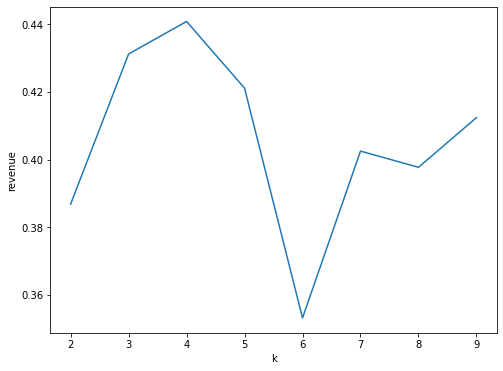

In [ ]:
#Visualizing the silhouette scores in a plot
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('revenue')



#Clustering using Kmeans

In [ ]:
final_clustering=KMeans(featuresCol='standardized', k=20)
KMeans_fit=final_clustering.fit(data_scale_output)
clusters_output=KMeans_fit.transform(data_scale_output)

In [ ]:
KMeans_fit.clusterCenters()
#print('cluster centers')
#for center in center:
 # print(center)

[array([3.49253085, 4.16176045, 1.72461016]),
 array([2.52478821, 3.29501065, 1.71767588]),
 array([1.98471636, 2.13157028, 0.33543826]),
 array([1.25953153, 3.81826145, 2.01375828]),
 array([2.39969088, 4.12231647, 0.35101935]),
 array([3.60180282, 3.26185465, 0.38389042]),
 array([3.50869499, 4.36918647, 5.69879895]),
 array([3.57248944, 7.34912795, 0.99736773]),
 array([3.21896184, 3.15217483, 3.5335095 ]),
 array([2.56514551, 3.01052506, 0.38778289]),
 array([3.69330565, 3.02494053, 1.60737204]),
 array([0.89046426, 1.69345188, 0.333914  ]),
 array([3.45915763, 2.08727947, 0.38779558]),
 array([1.92833237, 5.56228715, 0.92791159]),
 array([0.82884461, 4.25408873, 0.29512601]),
 array([3.65156798, 4.46144678, 0.45204304]),
 array([1.26525668, 2.34393225, 1.82142173]),
 array([1.23189291, 3.13996182, 0.29016647]),
 array([3.41619303, 4.69419811, 3.16969869]),
 array([2.9223489 , 2.15706509, 1.94176666])]

In [ ]:
transformed = KMeans_fit.transform(data_scale_output).select('userId', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(userId=937, prediction=2), Row(userId=1623, prediction=2), Row(userId=83, prediction=2)]


In [ ]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+------+----------+
|userId|prediction|
+------+----------+
|   937|         2|
|  1623|         2|
|    83|         2|
|   121|         2|
|   462|         2|
|   819|         2|
|  2199|         2|
|  1143|         2|
|  1652|         2|
|  2222|         2|
|   374|         2|
|  1535|         2|
|    21|         2|
|  2379|         2|
|  1807|         2|
|   868|         2|
|  1567|         2|
|   221|         2|
|  2306|         2|
|  1065|         2|
+------+----------+
only showing top 20 rows



In [ ]:
df_pred = df_pred.join(data_scale_output, 'userId')
df_pred.show()

+------+----------+---------+----------------+----------+-----------+---------+-------------------+-------+--------------------+--------------------+
|userId|prediction|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|       hit_accuracy|revenue|            features|        standardized|
+------+----------+---------+----------------+----------+-----------+---------+-------------------+-------+--------------------+--------------------+
|   937|         2|        1|              39|         0|          1|      1.0|                0.0|    1.0|       [1.0,0.0,1.0]|[0.55820147530917...|
|  1623|         2|        7|             102|        22|          1|     10.0|0.21568627450980393|   10.0|[7.0,0.2156862745...|[3.90741032716423...|
|  1623|         2|        6|              93|        11|          6|      9.0|0.11827956989247312|   54.0|[6.0,0.1182795698...|[3.34920885185505...|
|  1623|         2|        4|              82|         6|          2|     15.0|0.07317073170731707| 

In [ ]:
pddf_pred = df_pred.toPandas().set_index('userId')
pddf_pred.head()

,prediction,teamLevel,count_gameclicks,count_hits,count_buyId,avg_price,hit_accuracy,revenue,features,standardized
userId,,,,,,,,,,
937,2,1,39,0,1,1.0,0.000000,1.0,"[1.0, 0.0, 1.0]","[0.5582014753091764, 0.0, 0.07791326693814196]"
1623,2,7,102,22,1,10.0,0.215686,10.0,"[7.0, 0.21568627450980393, 10.0]","[3.907410327164235, 5.962355941739681, 0.77913..."
1623,2,6,93,11,6,9.0,0.118280,54.0,"[6.0, 0.11827956989247312, 54.0]","[3.3492088518550585, 3.2696790648249867, 4.207..."
1623,2,4,82,6,2,15.0,0.073171,30.0,"[4.0, 0.07317073170731707, 30.0]","[2.2328059012367056, 2.022706117707697, 2.3373..."
1623,2,1,129,9,1,10.0,0.069767,10.0,"[1.0, 0.06976744186046512, 10.0]","[0.5582014753091764, 1.9286267633957108, 0.779..."


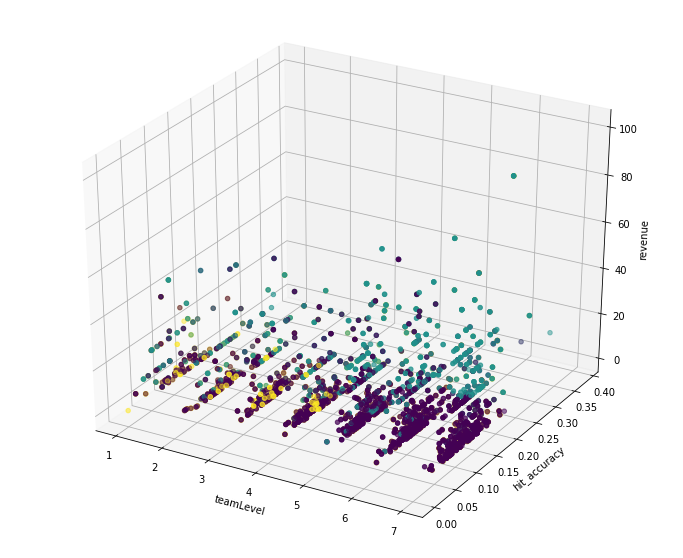

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.teamLevel, pddf_pred.hit_accuracy, pddf_pred.revenue, c=pddf_pred.prediction)
threedee.set_xlabel('teamLevel')
threedee.set_ylabel('hit_accuracy')
threedee.set_zlabel('revenue')
plt.show()

In [ ]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="standardized", outputCol="pca")
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [ ]:
cluster_assignment = np.array(clusters_output.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

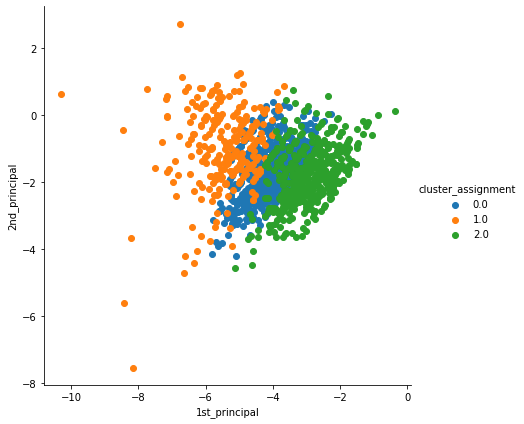

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [ ]:
#notice the last column [prediction]
clusters_output.show(50)

+------+---------+----------------+----------+-----------+---------+--------------------+-------+--------------------+--------------------+----------+
|userId|teamLevel|count_gameclicks|count_hits|count_buyId|avg_price|        hit_accuracy|revenue|            features|        standardized|prediction|
+------+---------+----------------+----------+-----------+---------+--------------------+-------+--------------------+--------------------+----------+
|   937|        1|              39|         0|          1|      1.0|                 0.0|    1.0|       [1.0,0.0,1.0]|[0.55820147530917...|         2|
|  1623|        1|             129|         9|          1|     10.0| 0.06976744186046512|   10.0|[1.0,0.0697674418...|[0.55820147530917...|         2|
|    83|        1|             102|        14|          1|      5.0| 0.13725490196078433|    5.0|[1.0,0.1372549019...|[0.55820147530917...|         2|
|   121|        1|              39|         4|          1|      3.0| 0.10256410256410256|    3

In [ ]:
KMeans_fit.transform(data_scale_output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  272|
|         2|  489|
|         0|  650|
+----------+-----+



In [ ]:
clusters_output1=clusters_output.toPandas()

In [ ]:
clusters_output1.head()

,userId,teamLevel,count_gameclicks,count_hits,count_buyId,avg_price,hit_accuracy,revenue,features,standardized,prediction
0,937,1,39,0,1,1.0,0.000000,1.0,"[1.0, 0.0, 1.0]","[0.5582014753091764, 0.0, 0.07791326693814196]",2
1,1623,1,129,9,1,10.0,0.069767,10.0,"[1.0, 0.06976744186046512, 10.0]","[0.5582014753091764, 1.9286267633957108, 0.779...",2
2,83,1,102,14,1,5.0,0.137255,5.0,"[1.0, 0.13725490196078433, 5.0]","[0.5582014753091764, 3.7942265083797975, 0.389...",2
3,121,1,39,4,1,3.0,0.102564,3.0,"[1.0, 0.10256410256410256, 3.0]","[0.5582014753091764, 2.8352461820860024, 0.233...",2
4,462,1,90,10,1,3.0,0.111111,3.0,"[1.0, 0.1111111111111111, 3.0]","[0.5582014753091764, 3.0715166972598356, 0.233...",2
